In [ ]:
import os
from autovc.speaker_encoder.utils import wav_to_mel_spectrogram
from autovc.utils.model_loader import load_model
from autovc.utils.core import retrieve_file_paths
import torch
from torch.utils.data import Dataset

class SpeakerEncoderDataLoader(Dataset):
    def __init__(self, data_dict):
        super().__init__()

        # Find wav files in dictionary of data        
        wav_files = [retrieve_file_paths(data_dir_path) for speaker_data_dir in data_dict.values() for data_dir_path in speaker_data_dir]

        # Compute mel spectograms
        speakers = len(data_dict.keys())
        self.datasets = [[wav_to_mel_spectrogram(wav) for wav in wav_files[i]] for i in range(speakers)]
        
        print(f"The datasets are of lengths: {[len(d) for d in self.datasets]}")

    def __getitem__(self, i):
        return tuple(d[i % len(d)] for d in self.datasets)

    def __len__(self):
        return max(len(d) for d in self.datasets)

    def collate_fn(self, batch):

        return batch

    def get_dataloader(self, batch_size=2, shuffle=False,  num_workers=0, pin_memory=False, **kwargs):
        return torch.utils.data.DataLoader(
            self,  
            batch_size      = batch_size, 
            num_workers     = num_workers, 
            shuffle         = shuffle,
            collate_fn      = self.collate_fn,
            drop_last       = True,
        )

datadir = {'hilde': ['data/conversions'], 'hague': ['data/conversions2'], 'peter':['data/new']}
Data = SpeakerEncoderDataLoader(datadir)




In [ ]:
from autovc.speaker_encoder.model import SpeakerEncoder
dataloader = Data.get_dataloader(batch_size = 2)
SE = SpeakerEncoder()


def batch_forward(batch):
    embeddings = []
    for b in batch:
        embed_speaker = torch.stack([SE.forward(torch.from_numpy(speaker).unsqueeze(0).to('cpu')) for speaker in b])
        embeddings.append(embed_speaker)
    return torch.cat(embeddings, dim = 1)
for i in range(5):
    for batch in dataloader:
        embeds = batch_forward(batch)
        print(embeds.shape)
        print(SE.similarity_matrix(embeds))

In [1]:
from autovc.utils.model_loader import load_model
from autovc.utils.dataloader import SpeakerEncoderDataLoader
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
datadir = {'hilde': ['data/hilde_20211020'], 'hague': ['data/HaegueYang_10sek', 'data/hyang_smk']}
Data = SpeakerEncoderDataLoader(datadir)

dataloader = Data.get_dataloader(batch_size=264)
SE = load_model('speaker_encoder', 'models/SpeakerEncoder/SpeakerEncoder.pt')


def batch_forward(batch):

    return torch.stack([SE(b) for b in batch])

# for i in range(1):
#     for batch in dataloader:
#         embeds = batch_forward(batch)
#         print(embeds.shape)
#         X = TSNE(n_components=2 ).fit_transform(torch.flatten(embeds, start_dim  = 0, end_dim = 1).detach().numpy())
#         plt.scatter(X[:, 0], X[:, 1])
#         plt.show()
#         print(SE.loss(embeds))

Creating mel spectograms ...
| ████████████████ 538/538 | The datasets are of lengths: [3435, 3628]
Loaded speaker encoder "models/SpeakerEncoder/SpeakerEncoder.pt" trained to step 1564501


torch.Size([2, 3628, 256])


/work3/s183922/AutoVC/AutoVC3-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/work3/s183922/AutoVC/AutoVC3-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


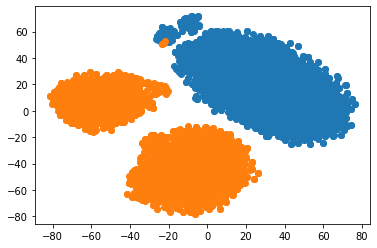

In [2]:
dataloader = Data.get_dataloader(batch_size=3628)
for batch in dataloader:
    embeds = batch_forward(batch)
    print(embeds.shape)
    X = TSNE(n_components=2 ).fit_transform(torch.flatten(embeds, start_dim  = 0, end_dim = 1).detach().numpy())
    
    plt.scatter(X[:len(X)//2,0], X[:len(X)//2,1])
    plt.scatter(X[len(X)//2:,0], X[len(X)//2:,1])
    plt.show()

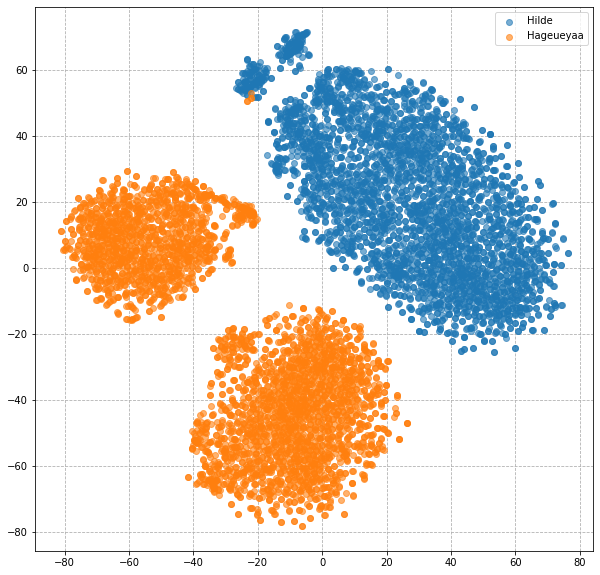

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(X[:len(X)//2,0], X[:len(X)//2,1], alpha = 0.6, zorder = 3)
ax.scatter(X[len(X)//2:,0], X[len(X)//2:,1], alpha = 0.6, zorder = 3)
ax.legend(["Hilde", "Hageueyaa"])
ax.grid(ls = '--')
plt.show()

In [16]:
embeds.shape

torch.Size([2, 3628, 256])